In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jaxlayerlumos import stackrt
from jaxlayerlumos.utils_materials import get_n_k_surrounded_by_air
from jaxlayerlumos.utils_spectra import get_frequencies_visible_light, convert_frequencies_to_wavelengths
from jaxlayerlumos.utils_layers import get_thicknesses_surrounded_by_air
from jaxlayerlumos.utils_units import convert_nm_to_m

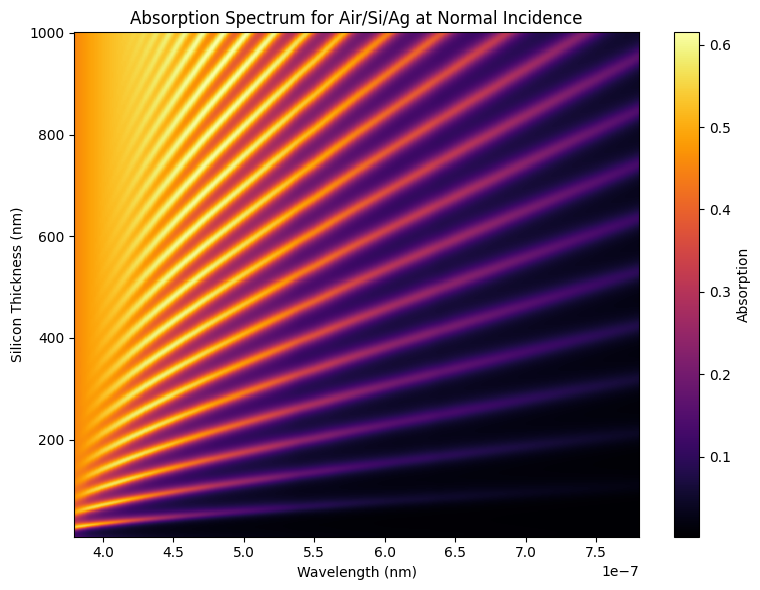

In [5]:

# Obtain the frequency grid for visible light (used here as a proxy for solar wavelengths)
frequencies = get_frequencies_visible_light()             # shape: (num_freq,)
wavelengths = convert_frequencies_to_wavelengths(frequencies)  # wavelengths in nm

# Define a range of silicon thicknesses in nm.
# You can adjust the range and number of points to suit your application.
silicon_thicknesses = jnp.linspace(10.0, 1000.0, 500)  # from 10 nm to 1000 nm (50 steps)

# Prepare a list to collect the absorption spectra for each silicon thickness.
absorption_spectra = []

# Use normal incidence.
angle = jnp.array([0.0])

# Loop over the range of silicon thickness values.
for t_si in silicon_thicknesses:
    # Create the thickness array for the internal layer.
    # get_thicknesses_surrounded_by_air adds semi-infinite air layers on both sides.
    # For a single internal layer (silicon) it returns an array: [0, t_si, 0]
    thicknesses = get_thicknesses_surrounded_by_air(jnp.array([t_si]))
    # Convert thicknesses from nm to m.
    layers = convert_nm_to_m(thicknesses)

    # Get the optical constants for a "Si" layer (with air on both sides).
    # This returns an array of shape (3, num_freq): [air, Si, air]
    n_k_stack = get_n_k_surrounded_by_air(["cSi"], frequencies)

    # Replace the default bottom ambient (air) with the metal substrate.
    # Here we use silver ("Ag") as our metal. For Ag, we extract the middle value,
    # which represents the metal optical constants.
    metal_n_k = get_n_k_surrounded_by_air(["Ag"], frequencies)[1, :]
    n_k_stack = n_k_stack.at[2].set(metal_n_k)

    # Compute the reflection and transmission coefficients using the transfer-matrix method.
    R_TE, T_TE, R_TM, T_TM = stackrt(n_k_stack, layers, frequencies, angle)

    # Remove the singleton angle dimension (squeeze the first axis) and compute the averages.
    R_TE_spec = jnp.squeeze(R_TE, axis=0)
    T_TE_spec = jnp.squeeze(T_TE, axis=0)
    R_TM_spec = jnp.squeeze(R_TM, axis=0)
    T_TM_spec = jnp.squeeze(T_TM, axis=0)

    R_avg = (R_TE_spec + R_TM_spec) / 2.0
    T_avg = (T_TE_spec + T_TM_spec) / 2.0

    # Compute the overall absorption of the stack.
    absorption = 1.0 - R_avg - T_avg

    # Append the absorption spectrum (converted to NumPy array) for this thickness.
    absorption_spectra.append(np.array(absorption))

# Convert the list of spectra into a 2D NumPy array.
# The resulting array has shape: (num_silicon_thicknesses, num_wavelengths)
absorption_spectra = np.array(absorption_spectra)

# Plot the absorption map as a function of wavelength and silicon thickness.
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(wavelengths, np.array(silicon_thicknesses))
pcm = plt.pcolormesh(X, Y, absorption_spectra, shading='auto', cmap='inferno')
plt.colorbar(pcm, label="Absorption")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Silicon Thickness (nm)")
plt.title("Absorption Spectrum for Air/Si/Ag at Normal Incidence")
plt.tight_layout()
plt.show()
